In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# To ensure GPU availability

In [ ]:
import tensorflow as tf

# List GPUs available
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"CUDA is available. GPU device name: {gpus[0].name}")

    # Set memory growth to prevent TensorFlow from allocating all GPU memory
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Use the first GPU by default
    with tf.device('/GPU:0'):
        # Your code (model training, inference, etc.)
        pass
else:
    print("CUDA is not available.")

CUDA is not available.


# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Keras imports
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Updated ImageDataGenerator import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Sklearn imports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# General imports
import random
import keras

import shutil

# Copy the data to working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define paths
data_path = '/content/drive/MyDrive/skinalyze_dataset/IMG_CLASSES'
output_path = '/kaggle/working/Skin-disease-images'


# Remove the existing dataset from the working directory if it exists
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Copy the dataset to a writable directory
if not os.path.exists(output_path):
    shutil.copytree(data_path, output_path)

# Checking Class distribution

Class counts: [2055, 3140, 7988, 2103, 1678, 1702, 2079, 1257, 3323, 1847]


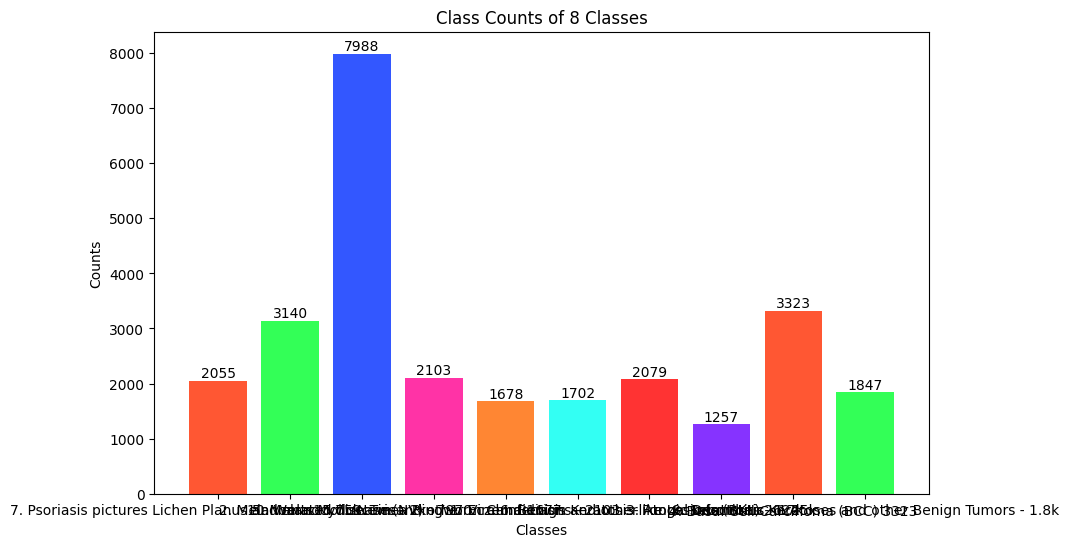

In [ ]:
# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

# Oversampling and Undersampling

In [ ]:
from PIL import Image
import numpy as np

# Oversampler function
def oversampler(class_name, class_count, target=7000, batch_size=32, target_size=(240, 240)):
    # Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(output_path, class_name)
    save_dir = curr_dir

    # Load images from the current class folder
    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target

    # Loop over images in batches, apply augmentation, and save them
    while cnt < target:
        batch_images = []

        # Load and resize images to the target size before converting to NumPy array
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)  # Resize the image
            img = np.array(img)  # Convert the PIL image to a NumPy array
            batch_images.append(img)

        batch_images = np.array(batch_images)  # Convert the list of images to a NumPy array

        # Process and augment the batch of images
        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break

        print(f"Processed {cnt}/{target} images for {class_name}")

# Undersampler function
def undersampler(class_name, class_count, target_count=7000):
    curr_dir = os.path.join(output_path, class_name)
    images = os.listdir(curr_dir)

    # Calculate the number of images to delete
    images_to_delete = random.sample(images, class_count - target_count)

    # Delete images in batches
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")

In [ ]:
# Oversample or undersample each class
for i, class_name in enumerate(classes):
    if class_counts[i] < 7000:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling and undersampling completed successfully.")

Processed 7015/7000 images for 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Processed 7012/7000 images for 2. Melanoma 15.75k
Deleted 988 images for 5. Melanocytic Nevi (NV) - 7970
Processed 7031/7000 images for 10. Warts Molluscum and other Viral Infections - 2103
Processed 7022/7000 images for 1. Eczema 1677
Processed 7014/7000 images for 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
Processed 7007/7000 images for 6. Benign Keratosis-like Lesions (BKL) 2624
Processed 7017/7000 images for 3. Atopic Dermatitis - 1.25k
Processed 7003/7000 images for 4. Basal Cell Carcinoma (BCC) 3323
Processed 7031/7000 images for 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Oversampling and undersampling completed successfully.


# Checking class imbalance

Class counts: [6973, 6993, 7000, 6988, 6973, 6975, 6983, 6975, 6981, 6978]


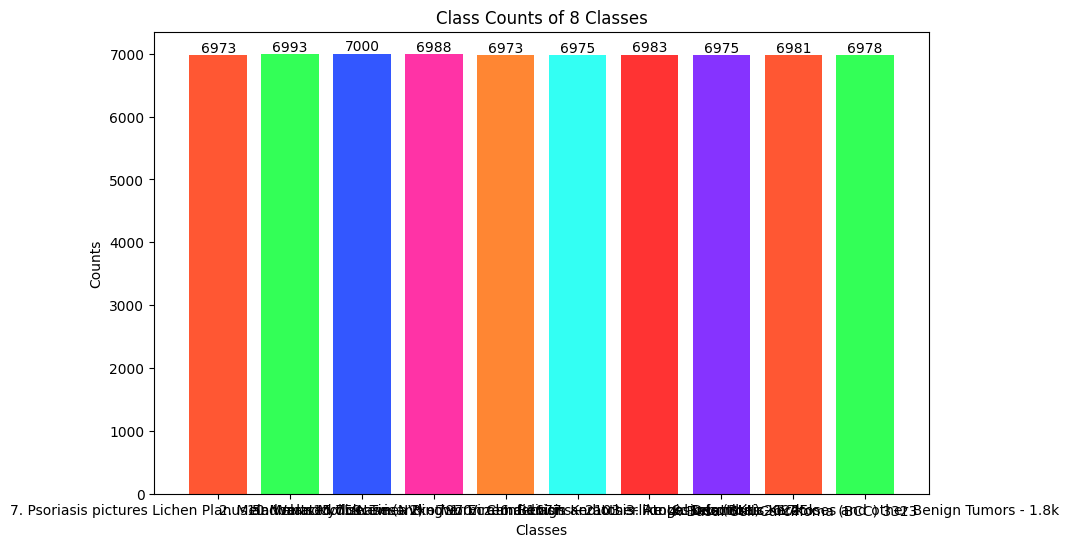

In [ ]:
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

# Train and Test Split

In [ ]:
import os
import random
import shutil

# Define paths for training, validation, and testing datasets
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

# Create directories for each dataset split
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the split ratios for train, validation, and test datasets
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Loop over each class in the output dataset and split it
for class_folder in os.listdir(output_path):  # using the output_path where dataset resides
    class_path = os.path.join(output_path, class_folder)

    # Create class directories in train, val, and test folders
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # List and shuffle the images in the current class folder
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)

    # Split the images based on the defined ratios
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val

    # Allocate images to each split
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    # Copy images to the appropriate directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

Dataset split completed successfully.


# Loading Images

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define image size and batch size
img_size = (256, 256)
batch_size = 32

# Paths to train and validation datasets (as defined in the previous steps)
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

# Create the train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

# Get the class names from the training dataset
class_names = train_dataset.class_names

# Create the validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

# Display class names (optional)
print("Class Names:", class_names)

Found 48870 files belonging to 10 classes.
Found 10468 files belonging to 10 classes.
Class Names: ['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


# Preprocessing the data

In [ ]:
import tensorflow as tf
# Preprocessing function
@tf.function
def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, [256, 256])
    # Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

# Model Building

In [47]:
from keras.applications.efficientnet import preprocess_input


# Feature extractor
# Feature extractor using EfficientNetB0
base_model = keras.applications.EfficientNetB0(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

for layer in base_model.layers:
    layer.trainable = False

# Build model
inputs = base_model.input
x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x) #output layer
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
# Train the model
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/50
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 458s 168ms/step - accuracy: 0.6754 - loss: 0.8171 - val_accuracy: 0.4818 - val_loss: 1.7593 - learning_rate: 1.0000e-04
Epoch 2/50
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 435s 160ms/step - accuracy: 0.6860 - loss: 0.7997 - val_accuracy: 0.4882 - val_loss: 1.7710 - learning_rate: 1.0000e-04
Epoch 3/50
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 434s 160ms/step - accuracy: 0.6986 - loss: 0.7821 - val_accuracy: 0.4972 - val_loss: 1.7648 - learning_rate: 1.0000e-04
Epoch 4/50
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 434s 160ms/step - accuracy: 0.6902 - loss: 0.7896 - val_accuracy: 0.4919 - val_loss: 1.8160 - learning_rate: 1.0000e-04
Epoch 5/50
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 442s 163ms/step - accuracy: 0.7050 - loss: 0.7560 - val_accuracy: 0.4963 - val_loss: 1.7969 - learning_rate: 2.0000e-05
Epoch 6/50
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 430s 158ms/step - accuracy: 0.7107 - loss: 0.7491 - val_accuracy: 0.4939 - val_loss: 1.8047 - learning_rate: 2.0000e-05


# Saving the model

In [ ]:
# Save the model after training
model_save_path = '/kaggle/working/my_model.h5'
model.save(model_save_path)

# Optionally, display a message confirming the model is saved
print(f'Model saved at {model_save_path}')

Model saved at /kaggle/working/my_model.h5


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load test dataset first WITHOUT mapping
raw_test_dataset = image_dataset_from_directory(
    '/kaggle/working/test',
    image_size=(256, 256),
    batch_size=32,
    shuffle=False  # Critical for matching predictions to labels
)

# Save class names before mapping
class_names = raw_test_dataset.class_names

# Now map and prefetch
test_dataset = raw_test_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

# Predict and gather labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Found 10481 files belonging to 10 classes.


KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: 2. Melanoma 15.75k
Confidence: 0.96


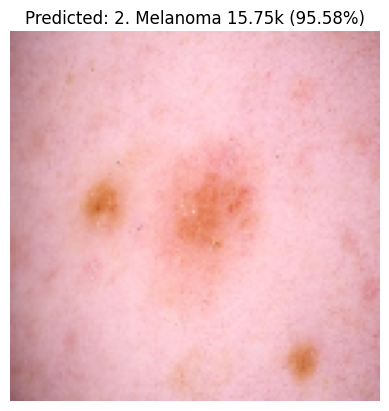

In [54]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to test
img_path = '/content/drive/MyDrive/skinalyze_dataset/IMG_CLASSES/2. Melanoma 15.75k/ISIC_7070936.jpg'

# Load and preprocess the image
def load_and_prepare_image(img_path, target_size=(128, 128)):  # <-- Match model input size
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)  # <-- Match MobileNetV2
    return np.expand_dims(img_array, axis=0), img  # Add batch dimension

# Load image
processed_img, original_img = load_and_prepare_image(img_path)

# Predict
pred_probs = model.predict(processed_img)
predicted_index = np.argmax(pred_probs)
confidence = np.max(pred_probs)

# Show result
print(f"Predicted Class: {class_names[predicted_index]}")
print(f"Confidence: {confidence:.2f}")

# Display image
plt.imshow(original_img)
plt.title(f"Predicted: {class_names[predicted_index]} ({confidence:.2%})")
plt.axis('off')
plt.show()


In [56]:
import json

# Save class names to a JSON file
class_names_path = '/kaggle/working/class_names.json'
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)

print(f"Class names saved to {class_names_path}")


Class names saved to /kaggle/working/class_names.json


✅ Model loaded successfully.
✅ Class names loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🧠 Predicted Class: 2. Melanoma 15.75k
📊 Confidence: 95.58%


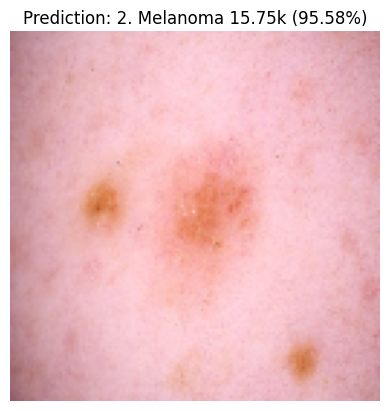

In [126]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # ✅ Correct preprocessing
import json

# --- STEP 1: Load trained model ---
model_path = '/kaggle/working/my_model.h5'
model = load_model(model_path)
print("✅ Model loaded successfully.")

# --- STEP 2: Load class names from saved file ---
class_names_path = '/kaggle/working/class_names.json'
with open(class_names_path, 'r') as f:
    class_names = json.load(f)

print("✅ Class names loaded.")

# --- STEP 3: Load and preprocess the image ---
def load_and_prepare_image(img_path, target_size=(128, 128)):  # ✅ Match your model's input size
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)  # ✅ Correct MobileNetV2 preprocessing
    return np.expand_dims(img_array, axis=0), img  # Add batch dimension

# --- STEP 4: Predict ---
img_path = '/content/drive/MyDrive/skinalyze_dataset/IMG_CLASSES/2. Melanoma 15.75k/ISIC_7070936.jpg'
processed_img, original_img = load_and_prepare_image(img_path)

pred_probs = model.predict(processed_img)
predicted_index = np.argmax(pred_probs)
confidence = np.max(pred_probs)
predicted_class = class_names[predicted_index]

# --- STEP 5: Show result ---
print(f"\n🧠 Predicted Class: {predicted_class}")
print(f"📊 Confidence: {confidence:.2%}")

plt.imshow(original_img)
plt.title(f"Prediction: {predicted_class} ({confidence:.2%})")
plt.axis('off')
plt.show()


In [ ]:
!pip install streamlit pyngrok tensorflow pillow


In [117]:
model.save("model.h5")


In [110]:
from pyngrok import ngrok

# Paste your actual token between the quotes
ngrok.set_auth_token("2yD92uSLrDIhv01Yn1r1dlujA2d_7dwsNimjRzC2aefz1HXao")

In [122]:
# Save model
model.save("model.h5")

# Run Streamlit app with ngrok
from pyngrok import ngrok
import threading
import time
import os

# Kill existing tunnels
ngrok.kill()

# Write the app.py again (optional if already done)
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os

# Load model
@st.cache_resource
def load_model():
    model_path = '/kaggle/working/my_model.h5'
    return tf.keras.models.load_model(model_path)

model = load_model()

# Class labels (must match training order)
CLASS_NAMES = [
    "Eczema",
    "Warts, Molluscum, and Other Viral Infections",
    "Melanoma",
    "Atopic Dermatitis",
    "Basal Cell Carcinoma (BCC)",
    "Melanocytic Nevi (NV)",
    "Benign Keratosis-like Lesions (BKL)",
    "Psoriasis, Lichen Planus, and Related Diseases",
    "Seborrheic Keratoses and Other Benign Tumors",
    "Tinea, Ringworm, Candidiasis, and Other Fungal Infections"
]
 # Adjust as per your model

# Streamlit page setup
st.set_page_config(page_title="Skinalyze - MobileNetV2 Skin Disease Detection")
st.title("🧑‍⚕️ Skinalyze - Skin Disease Detection (MobileNetV2)")
st.markdown("Upload a skin lesion image to detect the type of disease using MobileNetV2.")

# File uploader
uploaded_file = st.file_uploader("📁 Choose a skin lesion image...", type=["jpg", "jpeg", "png"])

# When file is uploaded
if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess the image (MobileNetV2 format)
    img_size = (128, 128)
    image = image.resize(img_size)
    image_array = np.array(image)
    image_array = preprocess_input(image_array)
    image_array = np.expand_dims(image_array, axis=0)

    if st.button("🔍 Predict"):
        prediction = model.predict(image_array)
        class_idx = np.argmax(prediction)
        confidence = np.max(prediction) * 100

        st.success(f"🩺 **Predicted Class:** {CLASS_NAMES[class_idx]}")
        st.info(f"📊 **Confidence:** {confidence:.2f}%")

""")

# Run Streamlit app in background
def run_streamlit():
    os.system("streamlit run app.py")

thread = threading.Thread(target=run_streamlit)
thread.start()

time.sleep(10)

# ✅ Use HTTPS tunnel
public_url = ngrok.connect("http://localhost:8501", bind_tls=True)
print(f"🌐 Streamlit app running at: {public_url}")


🌐 Streamlit app running at: NgrokTunnel: "https://ed6eaa0249a7.ngrok-free.app" -> "http://localhost:8501"
